In [13]:
"""
Deepfake Detection Training - Multi-Input CNN (COMPLETE FIXED VERSION)
Copy this entire file to your Jupyter notebook or run as .py
"""
import numpy as np
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, concatenate, Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC


In [14]:
# ============================================================
# GPU MEMORY CONFIGURATION
# ============================================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Memory Growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU Error: {e}")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU'))} device(s)")


TensorFlow version: 2.20.0
GPU available: 0 device(s)


In [15]:
# ============================================================
# PATHS & FILE LISTS
# ============================================================
FAKE_FREQ_DIR = "/Applications/Tien/deepfake/Dataset/features/fake/frequency"
FAKE_MOBILE_DIR = "/Applications/Tien/deepfake/Dataset/features/fake/mobilenet"
REAL_FREQ_DIR = "/Applications/Tien/deepfake/Dataset/features/real/frequency"
REAL_MOBILE_DIR = "/Applications/Tien/deepfake/Dataset/features/real/mobilenet"

print("\n" + "="*60)
print("SCANNING DATASET")
print("="*60)
fake_files = sorted([f for f in os.listdir(FAKE_FREQ_DIR) if f.endswith('.npy')])
real_files = sorted([f for f in os.listdir(REAL_FREQ_DIR) if f.endswith('.npy')])

print(f"Found {len(fake_files)} fake samples")
print(f"Found {len(real_files)} real samples")

# Check imbalance
imbalance_ratio = max(len(fake_files), len(real_files)) / min(len(fake_files), len(real_files))
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("WARNING: Severe class imbalance! Class weights are critical.")

# Create file lists with unique identifiers
file_list = []
for f in fake_files:
    file_list.append((f, 1, 'fake'))  # (filename, label, class)
for f in real_files:
    file_list.append((f, 0, 'real'))

print(f"Total: {len(file_list)} samples")

# Split into train/val/test
train_files, test_files = train_test_split(
    file_list, test_size=0.2, random_state=42, 
    stratify=[label for _, label, _ in file_list]
)
train_files, val_files = train_test_split(
    train_files, test_size=0.2, random_state=42,
    stratify=[label for _, label, _ in train_files]
)

print(f"\nTrain: {len(train_files)} samples ({len(train_files)/len(file_list)*100:.1f}%)")
print(f"Val:   {len(val_files)} samples ({len(val_files)/len(file_list)*100:.1f}%)")
print(f"Test:  {len(test_files)} samples ({len(test_files)/len(file_list)*100:.1f}%)")

# Data leakage check
train_set = set([(f, cls) for f, _, cls in train_files])
val_set = set([(f, cls) for f, _, cls in val_files])
test_set = set([(f, cls) for f, _, cls in test_files])

assert len(train_set & val_set) == 0, "Train/Val overlap detected!"
assert len(train_set & test_set) == 0, "Train/Test overlap detected!"
assert len(val_set & test_set) == 0, "Val/Test overlap detected!"
print("No data leakage detected")



SCANNING DATASET
Found 16201 fake samples
Found 16171 real samples
Imbalance ratio: 1.00:1
Total: 32372 samples

Train: 20717 samples (64.0%)
Val:   5180 samples (16.0%)
Test:  6475 samples (20.0%)
No data leakage detected


In [16]:
# ============================================================
# OPTIMIZED TF DATASET PIPELINE
# ============================================================
BATCH_SIZE = 16

def create_tf_dataset(file_list, batch_size=16, shuffle=True, augment=False):
    """Create optimized TensorFlow Dataset pipeline"""
    
    def load_data(filename, label, class_name):
        def _load_numpy(fname, lbl, cls):
            fname = fname.numpy().decode('utf-8')
            lbl = int(lbl.numpy())
            cls = cls.numpy().decode('utf-8')
            
            # Determine directories based on class
            if cls == 'fake':
                freq_dir = FAKE_FREQ_DIR
                mobile_dir = FAKE_MOBILE_DIR
            else:
                freq_dir = REAL_FREQ_DIR
                mobile_dir = REAL_MOBILE_DIR
            
            freq = np.load(os.path.join(freq_dir, fname))
            mobile = np.load(os.path.join(mobile_dir, fname))
            
            # Data Augmentation (ONLY for training)
            if augment:
                if np.random.rand() > 0.5:
                    k = np.random.randint(1, 4)
                    freq = np.rot90(freq, k=k, axes=(0, 1))
                
                if np.random.rand() > 0.5:
                    freq = np.flip(freq, axis=0)
                
                if np.random.rand() > 0.5:
                    freq = freq * np.random.uniform(0.9, 1.1)
            
            return freq.astype(np.float32), mobile.astype(np.float32), lbl
        
        freq, mobile, lbl = tf.py_function(
            _load_numpy, 
            [filename, label, class_name], 
            [tf.float32, tf.float32, tf.float32]
        )
        
        freq.set_shape([224, 224, 32])
        mobile.set_shape([1280])
        lbl.set_shape([])
        
        return (freq, mobile), lbl
    
    # Unpack file_list
    filenames, labels, class_names = zip(*file_list)
    dataset = tf.data.Dataset.from_tensor_slices((
        list(filenames), 
        list(labels), 
        list(class_names)
    ))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_list))
    
    dataset = (dataset
               .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE))
    
    return dataset

# Create datasets
print("\n" + "="*60)
print("CREATING DATASETS")
print("="*60)
print(f"Batch size: {BATCH_SIZE}")

train_dataset = create_tf_dataset(train_files, BATCH_SIZE, shuffle=True, augment=True)
val_dataset = create_tf_dataset(val_files, BATCH_SIZE, shuffle=False, augment=False)
test_dataset = create_tf_dataset(test_files, BATCH_SIZE, shuffle=False, augment=False)

steps_per_epoch = len(train_files) // BATCH_SIZE
validation_steps = len(val_files) // BATCH_SIZE
test_steps = len(test_files) // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")


CREATING DATASETS
Batch size: 16
Steps per epoch: 1294
Validation steps: 323
Test steps: 404


In [17]:
# ============================================================
# BUILD MODEL
# ============================================================
print("\n" + "="*60)
print("BUILDING MODEL")
print("="*60)

# Input layers
input_freq = Input(shape=(224, 224, 32), name='frequency_input')
input_mobile = Input(shape=(1280,), name='mobilenet_input')

# Frequency CNN branch
x1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_freq)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D((2,2))(x1)
x1 = SpatialDropout2D(0.2)(x1)

x1 = Conv2D(64, (3,3), activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D((2,2))(x1)
x1 = SpatialDropout2D(0.2)(x1)

x1 = Conv2D(128, (3,3), activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = GlobalAveragePooling2D()(x1)

x1 = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x1)
x1 = Dropout(0.3)(x1)

# MobileNet FC branch
x2 = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_mobile)
x2 = Dropout(0.3)(x2)
x2 = Dense(64, activation='relu')(x2)
x2 = Dropout(0.3)(x2)

# Fusion
merged = concatenate([x1, x2], name='fusion')

# Classification head
x = Dense(64, activation='relu')(merged)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[input_freq, input_mobile], outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

model.summary()


BUILDING MODEL


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frequency_input     │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │      9,248 │ frequency_input[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_2 │ (None, 112, 112,  │          0 │ max_pooling2d_2[… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     18,496 │ spatial_dropout2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_3 │ (None, 56, 56,    │          0 │ max_pooling2d_3[… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     73,856 │ spatial_dropout2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_input     │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    327,936 │ mobilenet_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     16,448 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 465,505 (1.78 MB)

 Trainable params: 465,057 (1.77 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
# ============================================================
# CALLBACKS & CLASS WEIGHTS
# ============================================================
print("\n" + "="*60)
print("PREPARING TRAINING")
print("="*60)

# Calculate class weights (FIXED: unpack 3 elements)
labels = [label for _, label, _ in train_files]
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(labels), 
    y=labels
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-7
    )
]



PREPARING TRAINING
Class weights: {0: np.float64(1.000917963088221), 1: np.float64(0.9990837191358025)}


In [19]:
# ============================================================
# TRAIN MODEL
# ============================================================
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)


STARTING TRAINING
Epoch 1/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5352 - auc: 0.5541 - loss: 1.2840 - precision: 0.5329 - recall: 0.5033
Epoch 1: val_accuracy improved from None to 0.70463, saving model to best_model.keras
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 646s 497ms/step - accuracy: 0.5796 - auc: 0.6182 - loss: 0.8471 - precision: 0.5805 - recall: 0.5770 - val_accuracy: 0.7046 - val_auc: 0.7751 - val_loss: 0.6270 - val_precision: 0.7212 - val_recall: 0.6678 - learning_rate: 0.0010
Epoch 2/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.6607 - auc: 0.7195 - loss: 0.6626 - precision: 0.6483 - recall: 0.7033
Epoch 2: val_accuracy did not improve from 0.70463
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 708s 546ms/step - accuracy: 0.6704 - auc: 0.7283 - loss: 0.6564 - precision: 0.6583 - recall: 0.7099 - val_accuracy: 0.7006 - val_auc: 0.7935 - val_loss: 0.6265 - val_precision: 0.7633 - val_recall: 0.5822 - learning_rate: 0.0010
Epoch 3/50
1295/1295 ━━━━━━━━━━━━━━━━━━━

In [20]:
# ============================================================
# EVALUATE MODEL
# ============================================================
print("\n" + "="*60)
print("EVALUATING MODEL")
print("="*60)

test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_dataset,
    verbose=1
)

print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc*100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test AUC:       {test_auc:.4f}")
print(f"{'='*60}")

# Generate predictions
print("\nGenerating predictions...")
y_pred_proba = model.predict(test_dataset, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Get true labels (FIXED: unpack 3 elements)
y_test = np.array([label for _, label, _ in test_files])

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)



EVALUATING MODEL
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.8403 - auc: 0.9202 - loss: 0.4020 - precision: 0.8168 - recall: 0.8778

FINAL RESULTS
Test Loss:      0.4020
Test Accuracy:  84.03%
Test Precision: 0.8168
Test Recall:    0.8778
Test AUC:       0.9202

Generating predictions...
405/405 ━━━━━━━━━━━━━━━━━━━━ 61s 150ms/step

Classification Report:
              precision    recall  f1-score   support

        Real       0.87      0.80      0.83      3234
        Fake       0.82      0.88      0.85      3241

    accuracy                           0.84      6475
   macro avg       0.84      0.84      0.84      6475
weighted avg       0.84      0.84      0.84      6475


Confusion Matrix:
[[2596  638]
 [ 396 2845]]



GENERATING VISUALIZATIONS


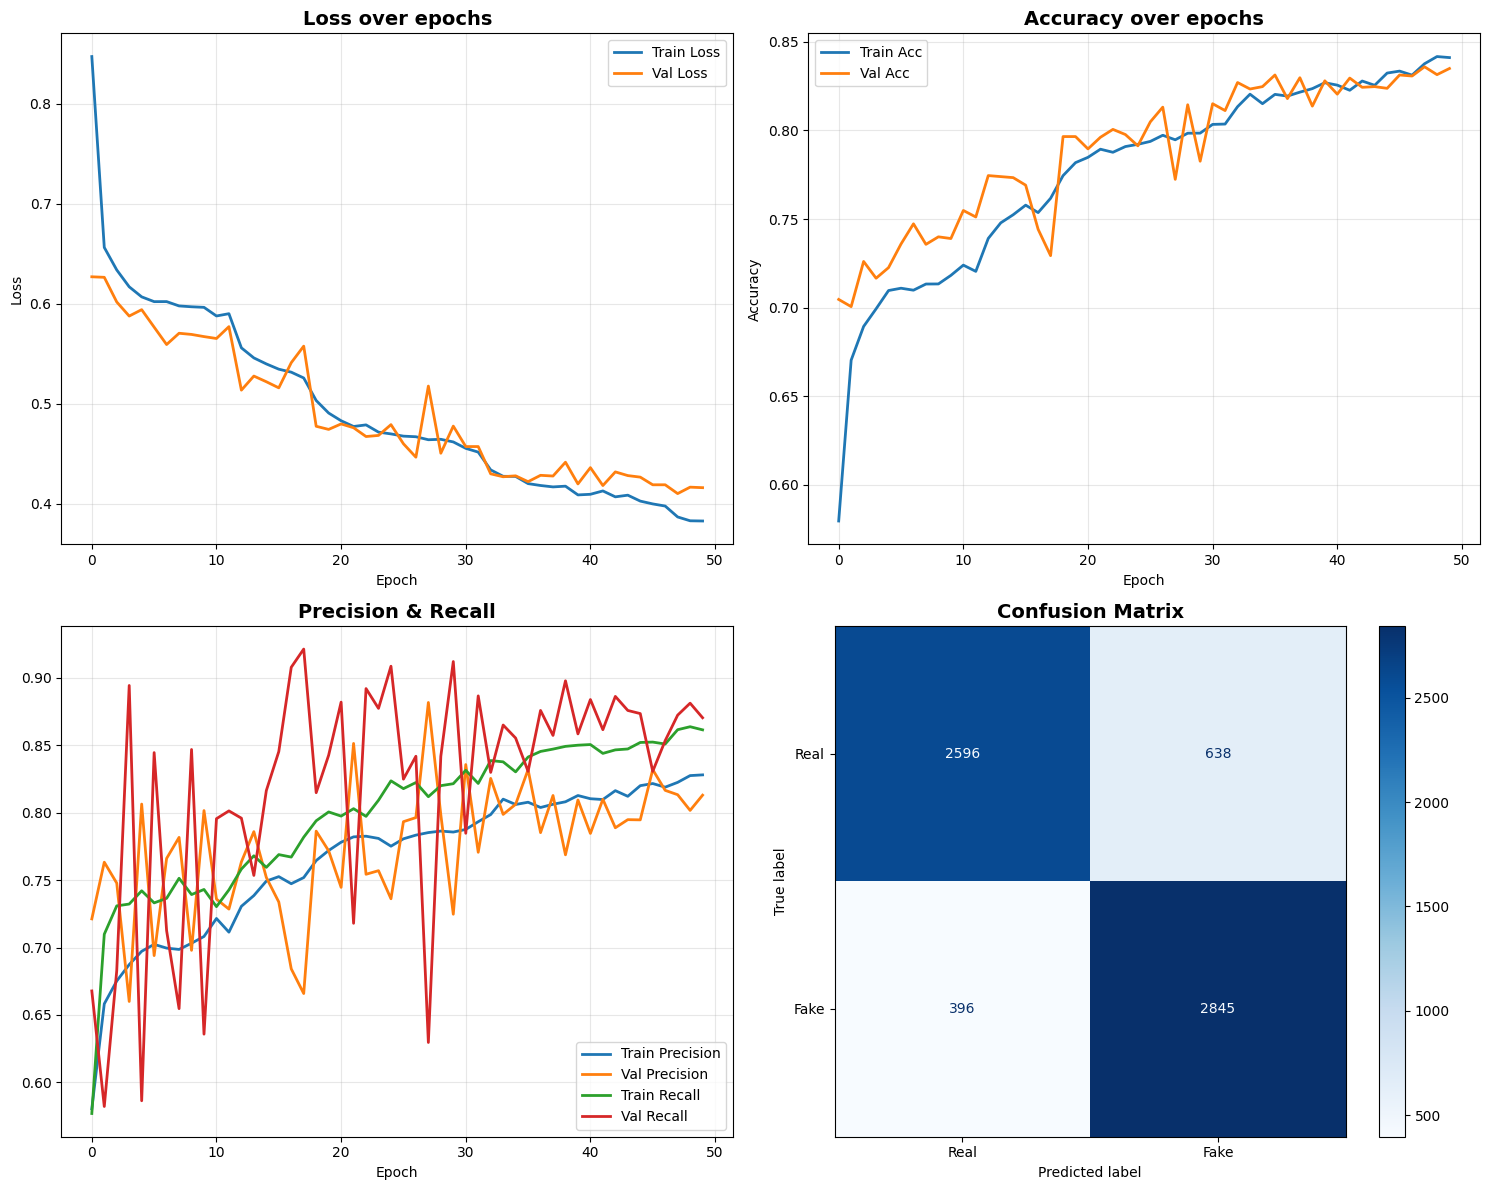

Results saved to: training_results.png


In [21]:
# ============================================================
# VISUALIZE RESULTS
# ============================================================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Loss over epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0, 1].set_title('Accuracy over epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 0].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 0].set_title('Precision & Recall', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues', ax=axes[1, 1], values_format='d')
axes[1, 1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("Results saved to: training_results.png")



SAMPLE PREDICTIONS


2025-10-08 16:35:44.335739: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


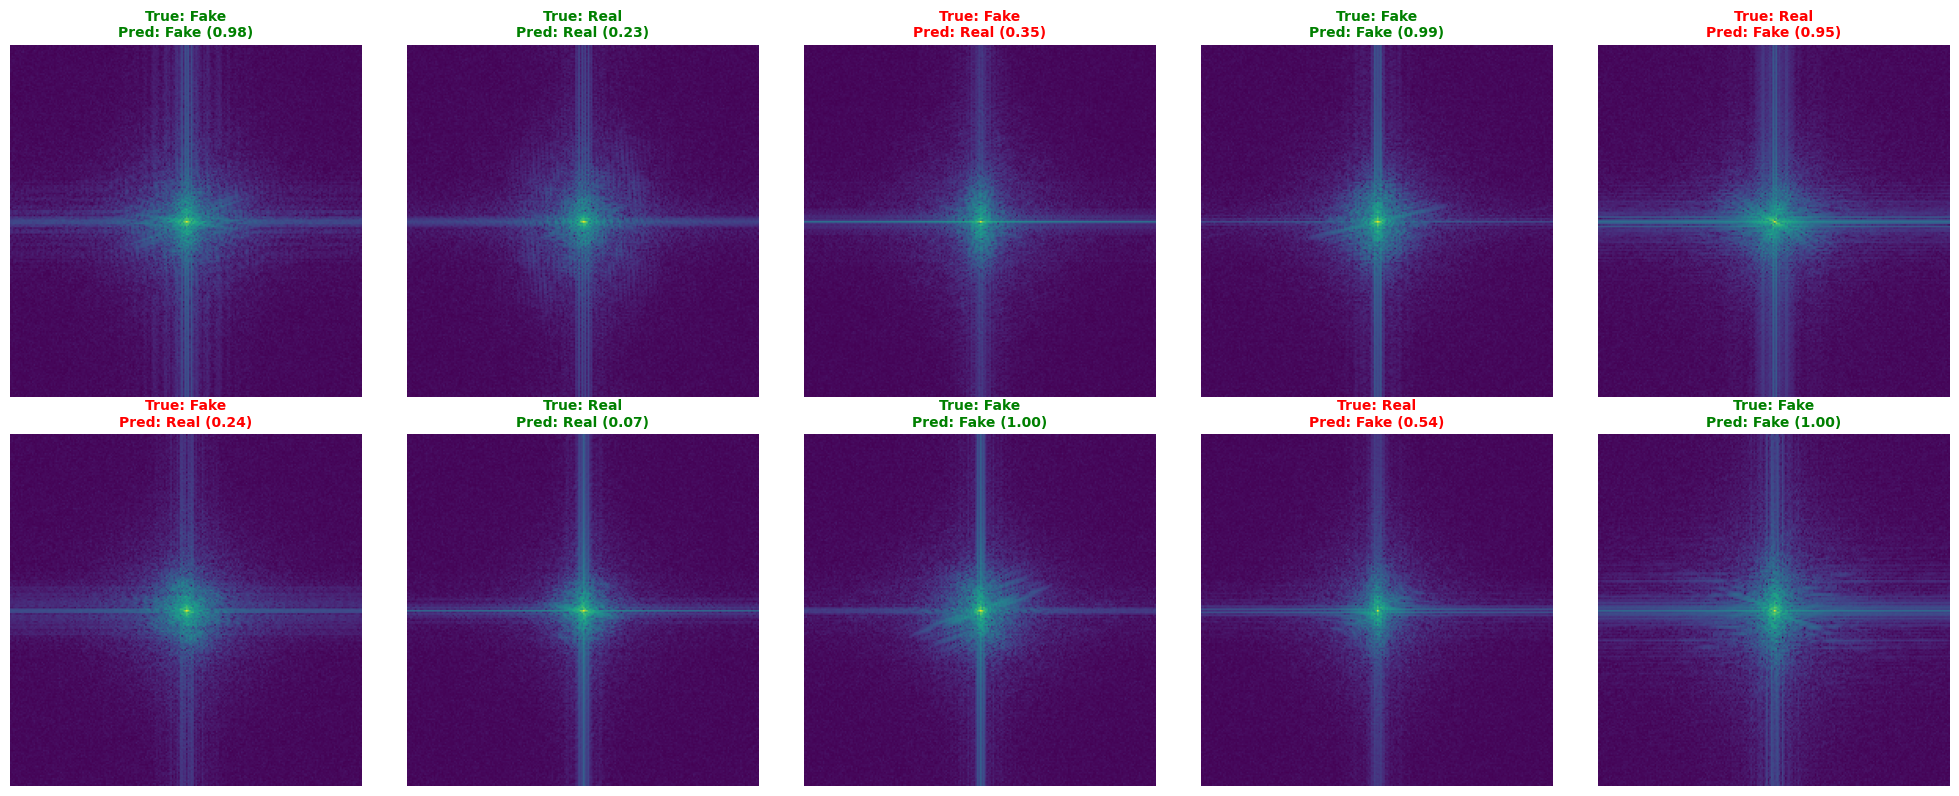

Predictions saved to: sample_predictions.png


In [22]:
# ============================================================
# SAMPLE PREDICTIONS
# ============================================================
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

sample_data = list(test_dataset.take(1))[0]
X_sample = sample_data[0]
y_sample = sample_data[1].numpy()

X_freq_sample = X_sample[0][:10]
X_mobile_sample = X_sample[1][:10]
y_sample = y_sample[:10]

y_pred_sample = model.predict([X_freq_sample, X_mobile_sample], verbose=0)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(min(10, len(X_freq_sample))):
    ax = axes[i // 5, i % 5]
    
    freq_img = X_freq_sample[i][:, :, 0]
    ax.imshow(freq_img, cmap='viridis')
    
    pred_prob = y_pred_sample[i][0]
    true_label = "Fake" if y_sample[i] == 1 else "Real"
    pred_label = "Fake" if pred_prob > 0.5 else "Real"
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})", 
                 color=color, fontweight='bold', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Predictions saved to: sample_predictions.png")


In [23]:
# ============================================================
# SAVE MODEL
# ============================================================
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

model.save('deepfake_detection_model.keras')
print("Model saved: deepfake_detection_model.keras")

model_size = os.path.getsize('deepfake_detection_model.keras') / 1024 / 1024
print(f"Model size: {model_size:.2f} MB")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


SAVING MODEL
Model saved: deepfake_detection_model.keras
Model size: 5.42 MB

TRAINING COMPLETE!
